# Main

## Librerias a utilizar

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
import sys
import ctypes
import subprocess

In [3]:
subprocess.run(['gcc', '-shared', '-o', 'libtarea3.so', '-fPIC', '-O3', 'libtarea3.c'])

CompletedProcess(args=['gcc', '-shared', '-o', 'libtarea3.so', '-fPIC', '-O3', 'libtarea3.c'], returncode=0)

## Importando CSV

In [3]:
df_names = pd.read_table('Popular-Baby-Names-Final.csv',
                         dtype={"Name": "string"})
df_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93889 entries, 0 to 93888
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    93888 non-null  string
dtypes: string(1)
memory usage: 733.6 KB


In [4]:
df_names.sort_values(by="Name", inplace=True, ignore_index=True)
list_names = df_names.dropna().Name.to_list()
del df_names

In [ ]:
sys.getsizeof(list_names)/1024

In [ ]:
df_movie = pd.read_csv("Film-Names.csv",
                       skiprows=1,
                       names=["Name"],
                       dtype={"Name": "string"})
df_movie.info()

In [ ]:
df_movie.replace(";","", regex=True, inplace=True)
df_movie["Name"].map(lambda x: x not in list_names)
df_movie.dropna(subset=["Name"], inplace=True)
df_movie.sort_values(by="Name",ignore_index=True,inplace=True)
list_movies = df_movie.dropna().Name.to_list()
del df_movie

In [ ]:
sys.getsizeof(list_movies)/1024

## Creando el Filtro Bloom

### Importando las funciones de C

In [ ]:
# Cargar la biblioteca compartida
lib = ctypes.CDLL('./libtarea3.so')

# Definir la función siguiente_primo
siguiente_primo = lib.siguiente_primo
siguiente_primo.argtypes = [ctypes.c_ulonglong]
siguiente_primo.restype = ctypes.c_ulonglong

# Definir la función funcion_hash
funcion_hash = lib.funcion_hash
funcion_hash.argtypes = [ctypes.c_ulonglong, ctypes.c_ulonglong, ctypes.c_ulonglong, ctypes.c_ulonglong, ctypes.c_ulonglong]
funcion_hash.restype = ctypes.c_ulonglong


In [ ]:
# Ejemplo de uso de la función siguiente_primo
resultado = siguiente_primo(5)
print(resultado)

# Ejemplo de uso de la función funcion_hash
resultado = funcion_hash(3, 5, 7, 10, 2)
print(resultado)

In [ ]:
def generador_fun_hash(a, b, p, m):
    def mask_hash(key):
        return funcion_hash(a, b, p, m, int.from_bytes(str(key).encode('utf-8'), byteorder='big'))
    return mask_hash

aux_hash = generador_fun_hash(10,10,13,2)
aux_hash(b"hola")

In [ ]:
# Ejemplo de creación de 20 funciones hash distintas
n = 10
rng = np.random.default_rng(seed=1234)
p_hash = rng.integers(low=0,high=2**10,size=n).tolist() # Parametro p
a_hash = [rng.integers(low=1,high=siguiente_primo(p)) for p in p_hash]
b_hash = [rng.integers(low=0,high=siguiente_primo(p)) for p in p_hash]
list_hash_func = [generador_fun_hash(a,b,siguiente_primo(p),100) for a,b,p in zip(a_hash,b_hash,p_hash)]


for i in range(n):
    print(list_hash_func[i](b"hola"))

## Creando búsquedas

In [ ]:
#The optimal number of hash functions is k = int ((m/n)*ln(2))
#where m is the size of the bit array and n is the number of items to be inserted in the filter.

#the optimal size of the bit array is m = int(-(n*ln(p))/(ln(2)^2)),
#where p is the desired false positive probability.

#The probability of false positives is given by the equation (1 - (1 - 1/m)^(kn))^k

class DBBloomFilter():

	def __init__(self, m: int, list_hash: list, database: list[str]):
		# Bit array of given size
		self.bit_array = np.zeros(m, dtype=np.bool_) # initialize all bits as 0
  
		self.db = database.copy()
        # list of hash functions to use
		self.list_fun_hash = list_hash.copy()

		for item in self.db:
			for fun_hash in self.list_fun_hash:
       			# set the bit True in bit_array
				self.bit_array[fun_hash(item)] = True

    #Check if an item is present in the filter
	def check_filter(self, item: str) -> bool:
		for fun_hash in self.list_fun_hash:
			if self.bit_array[fun_hash(item)] == False:
				# if any of bit is False then,its not present
				# if not, there is probability that it exist
				return False
		return True

	def check_db(self, item: str) -> bool:
		return item in self.db

## Experimentos

In [ ]:
word_search = []
value_filter = []
value_search = []
time_filter = []
time_search = []
num_funct_hash = []
size_array = []

# Condiciones del experimento
k_max = 20
num_M = 1000
seed = 1234
rng = np.random.default_rng(seed=seed)
database = list_names
data_false = list_movies
size_test = 100

#
p_hash = rng.integers(low=0,high=2**30,size=k_max).tolist() # Parametro p
a_hash = [rng.integers(low=1,high=siguiente_primo(p)) for p in p_hash] # Parametro a
b_hash = [rng.integers(low=0,high=siguiente_primo(p)) for p in p_hash] # Parametro b


sample_database = rng.choice(database, size=size_test,replace=False).astype(str,copy=False)
sample_data_false = rng.choice(data_false, size=size_test,replace=False).astype(str,copy=False)

for M in (2**(np.linspace(1,32, num_M))).astype(np.int64).tolist():
    list_hash_func = [generador_fun_hash(a,b,siguiente_primo(p),M) for a,b,p in zip(a_hash,b_hash,p_hash)]
    for k in range(1,k_max):
        # Creamos un objeto que nos ayudara con los procesos internos
        test = DBBloomFilter(m=M, list_hash=list_hash_func[:k], database=database)
        
        
        word_search += [txt for txt in sample_database]
        num_funct_hash += [k for _ in sample_database]   
        size_array += [M for _ in sample_database]
        
        for name in sample_database:
            # Busqueda en el filtro   
            init_time = time.perf_counter_ns()
            res = test.check_filter(name)
            time_filter.append(time.perf_counter_ns()-init_time)
            value_filter.append(res)
            # Busqueda en la DB
            init_time = time.perf_counter_ns()
            res = test.check_db(name)
            time_search.append(time.perf_counter_ns()-init_time)
            value_search.append(res)

        # Ahora analizamos los tiempos de las busquedas infrutiferas
        word_search += [txt for txt in sample_data_false]
        num_funct_hash += [k for _ in sample_data_false]   
        size_array += [M for _ in sample_data_false]
        for name in sample_data_false:
            # Busqueda en el filtro   
            init_time = time.perf_counter_ns()
            res = test.check_filter(name)
            time_filter.append(time.perf_counter_ns()-init_time)
            value_filter.append(res)
            # Busqueda en la DB
            init_time = time.perf_counter_ns()
            res = test.check_db(name)
            time_search.append(time.perf_counter_ns()-init_time)
            value_search.append(res)
        
        # Liberamos memoria y dejamos la variable test limpia
        del test

dict_data = {"WordSearch":word_search,
             "ValueFilter":value_filter,
             "ValueSearch":value_search,
             "TimeFilter":time_filter,
             "TimeSearch":time_search,
             "NumFunctHash": num_funct_hash,
             "SizeArray": size_array,
             }

df = pd.DataFrame(dict_data)

df.to_csv("resultados.txt", index=False)

# Gráficos

In [4]:
dataset = pd.read_csv("resultados.txt", dtype={"WordSearch":"string",
                                               "ValueFilter":np.bool_,
                                               "ValueSearch":np.bool_,
                                               "TimeFilter":np.uint64,
                                               "TimeSearch":np.uint64,
                                               "NumFunctHash": np.uint64,
                                               "SizeArray": np.uint64,
                                               },
                      )
dataset

,WordSearch,ValueFilter,ValueSearch,TimeFilter,TimeSearch,NumFunctHash,SizeArray
0,CYPRUS,True,True,38400,673200,1,2
1,RAIVYN,True,True,10200,1979700,1,2
2,EZQUIEL,True,True,13400,395400,1,2
3,GUST,True,True,8300,303300,1,2
4,JEDI,True,True,6300,383500,1,2
...,...,...,...,...,...,...,...
3799995,THE BABY,False,False,9100,1111200,19,4294967296
3799996,CHEZ WHOOPI,False,False,10900,931600,19,4294967296
3799997,STEPHEN KING'S IT,False,False,9000,923600,19,4294967296
3799998,BABY BOOM,False,False,8900,998200,19,4294967296


In [5]:
dataset.dropna(inplace=True)
dataset.reset_index(drop=True,inplace=True)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800000 entries, 0 to 3799999
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   WordSearch    string
 1   ValueFilter   bool  
 2   ValueSearch   bool  
 3   TimeFilter    uint64
 4   TimeSearch    uint64
 5   NumFunctHash  uint64
 6   SizeArray     uint64
dtypes: bool(2), string(1), uint64(4)
memory usage: 152.2 MB


In [7]:
dataset["RealTimeSearch"] = [(dataset.loc[i,"TimeFilter"] + dataset.loc[i,"TimeSearch"] if dataset.loc[i,"ValueFilter"] else dataset.loc[i,"TimeFilter"]) for i in range(dataset.shape[0])]

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800000 entries, 0 to 3799999
Data columns (total 8 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   WordSearch      string
 1   ValueFilter     bool  
 2   ValueSearch     bool  
 3   TimeFilter      uint64
 4   TimeSearch      uint64
 5   NumFunctHash    uint64
 6   SizeArray       uint64
 7   RealTimeSearch  uint64
dtypes: bool(2), string(1), uint64(5)
memory usage: 181.2 MB


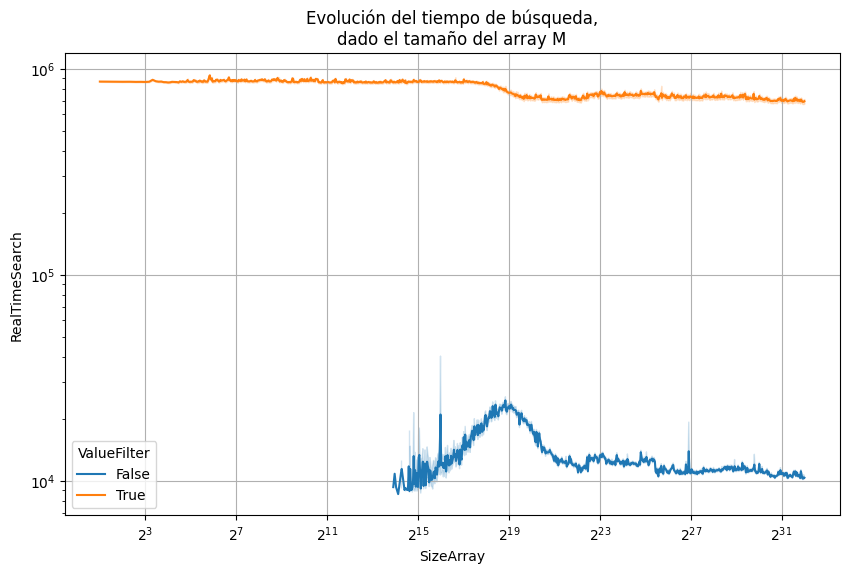

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="SizeArray",
             hue="ValueFilter",
             estimator="mean",
             ax = ax,
             )

ax.set_xscale("log", base = 2)
ax.set_yscale("log", base = 10)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el tamaño del array M")
ax.grid(True)
plt.show()

Se logra observar que es muy eficiente el filtro, cuando queremos negar la existencia de un elemento en la base de datos, tan así que la diferencia de los tiempos son de al menos 2 ordenes de magnitud, pero siempre y cuando exista un largo mínimo del tamaño del array del Filtro Bloom. En caso contrario, solo da falsos positivos, lo que implica que el filtro solo nos generará un costo mayor de tiempo innecesario.

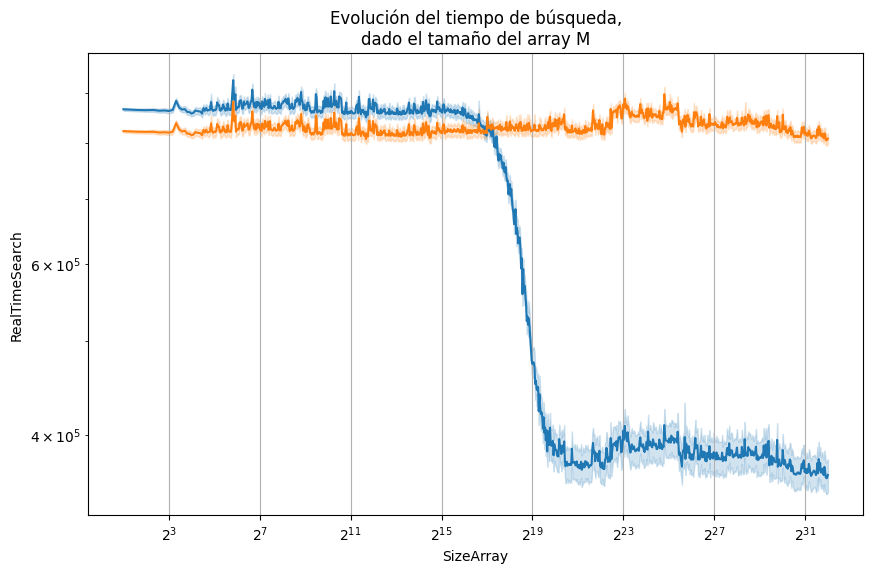

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="SizeArray",
             estimator="mean",
             ax = ax,
             )
sns.lineplot(dataset,
             y="TimeSearch",
             x="SizeArray",
             estimator="mean",
             ax = ax,
             )

ax.set_xscale("log", base = 2)
ax.set_yscale("log", base = 10)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el tamaño del array M")
ax.grid(True)
plt.show()

Al igual que en la observación anterior, pero con mucha mayor claridad, se puede observar que existe un largo mínimo que debe tener el filtro tal que este genere mejores tiempos promedios de búsqueda, sino entrega tiempos promedios peores que sin el filtro.

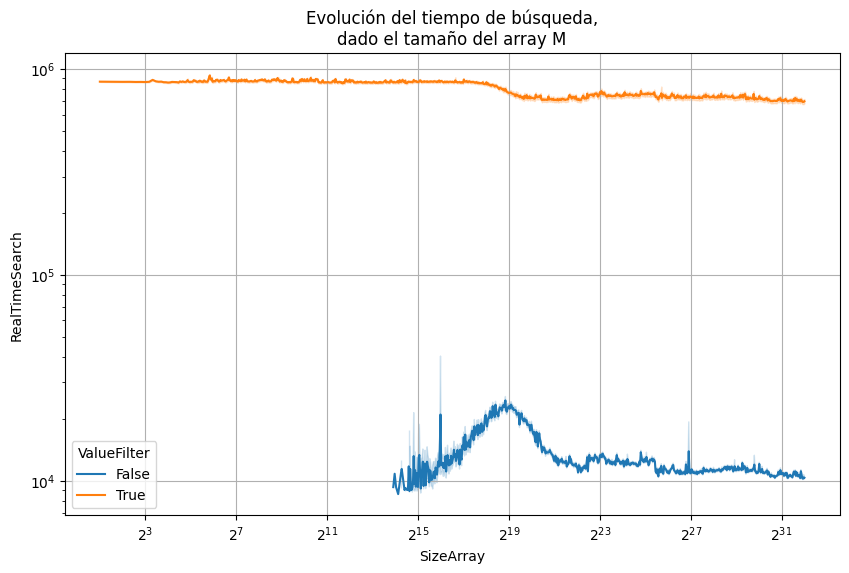

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="SizeArray",
             hue="ValueFilter",
             estimator="mean",
             ax = ax,
             )

ax.set_xscale("log", base = 2)
ax.set_yscale("log", base = 10)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el tamaño del array M")
ax.grid(True)
plt.show()

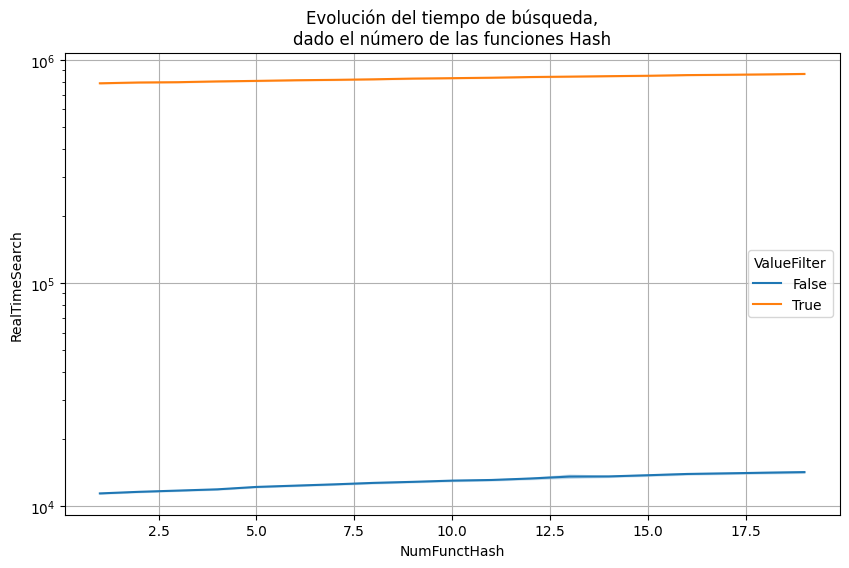

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="NumFunctHash",
             hue="ValueFilter",
             estimator="mean",
             ax=ax
             )
ax.set_yscale("log", base = 10)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el número de las funciones Hash")
ax.grid(True)
plt.show()

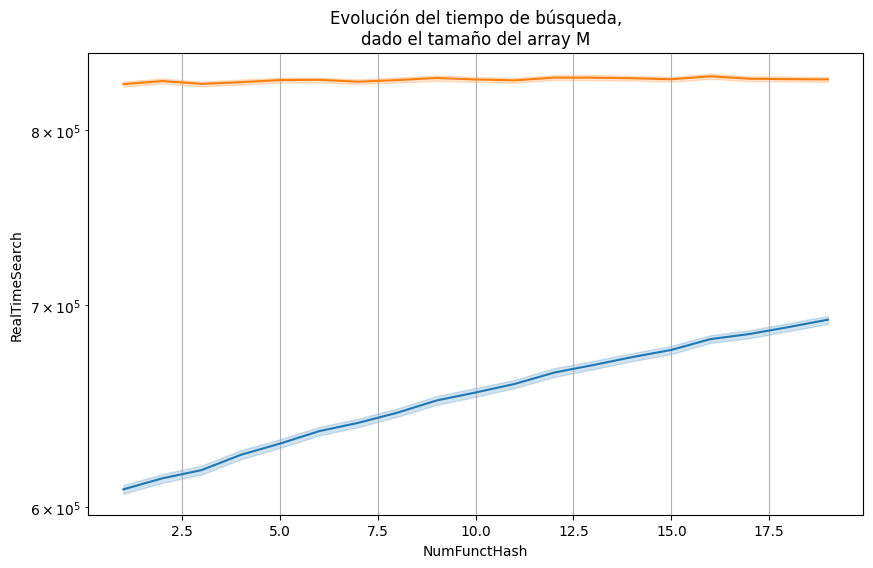

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="NumFunctHash",
             estimator="mean",
             ax = ax,
             )
sns.lineplot(dataset,
             y="TimeSearch",
             x="NumFunctHash",
             estimator="mean",
             ax = ax,
             )

ax.set_yscale("log", base = 10)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el tamaño del array M")
ax.grid(True)
plt.show()

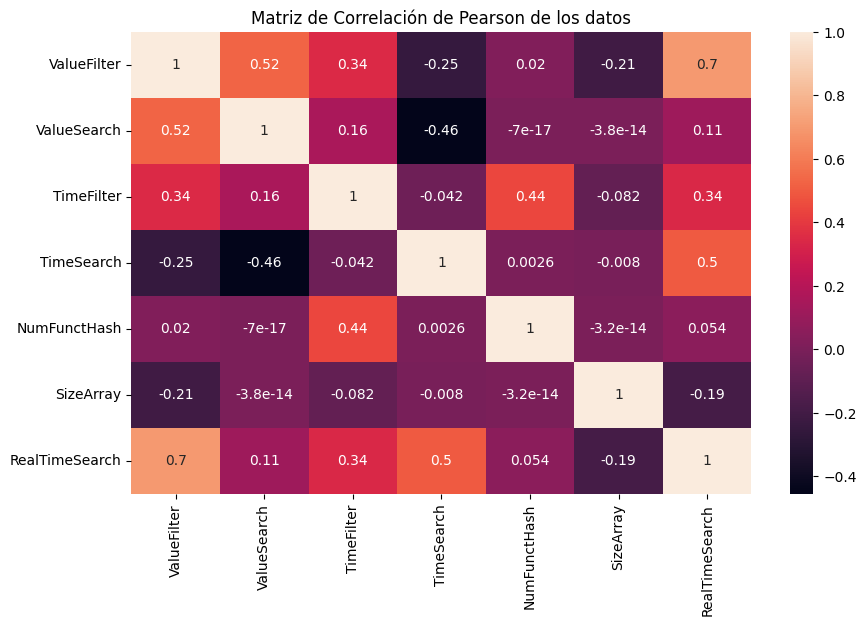

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(dataset.corr(numeric_only=True),
            annot=True,
            ax=ax)
ax.set_title("Matriz de Correlación de Pearson de los datos")
plt.show()

In [15]:
df_filter_bloom_stats = pd.DataFrame()

df_filter_bloom_stats["NumFunctHash"] = dataset["NumFunctHash"].unique()
df_filter_bloom_stats = df_filter_bloom_stats.merge(pd.DataFrame({"SizeArray": dataset["SizeArray"].unique()}), how="cross")
true_positive = []
false_positive = []
true_negative = []
false_negative = []
real_time_mean = []
real_time_std = []
for k, M in df_filter_bloom_stats.iloc:
    df_aux = dataset[(dataset["SizeArray"] == M) &
                     (dataset["NumFunctHash"] == k)][["ValueSearch","ValueFilter","RealTimeSearch"]]
    true_positive += [len(df_aux[(df_aux["ValueSearch"] == True) & (df_aux["ValueFilter"] == True)])]
    false_positive += [len(df_aux[(df_aux["ValueSearch"] == False) & (df_aux["ValueFilter"] == True)])]
    true_negative += [len(df_aux[(df_aux["ValueSearch"] == False) & (df_aux["ValueFilter"] == False)])]
    false_negative += [len(df_aux[(df_aux["ValueSearch"] == True) & (df_aux["ValueFilter"] == False)])]
    real_time_mean += [len(df_aux["RealTimeSearch"].mean())]
    real_time_std += [len(df_aux["RealTimeSearch"].std())]

df_filter_bloom_stats["TruePositive"] = true_positive
df_filter_bloom_stats["FalsePositive"] = false_positive
df_filter_bloom_stats["TrueNegative"] = true_negative
df_filter_bloom_stats["FalseNegative"] = false_negative

df_filter_bloom_stats["RateFalsePositive"] = df_filter_bloom_stats["FalsePositive"]/(df_filter_bloom_stats["FalsePositive"] + df_filter_bloom_stats["TruePositive"])
df_filter_bloom_stats["RateFalseNegative"] = df_filter_bloom_stats["FalseNegative"]/(df_filter_bloom_stats["FalseNegative"] + df_filter_bloom_stats["TrueNegative"])

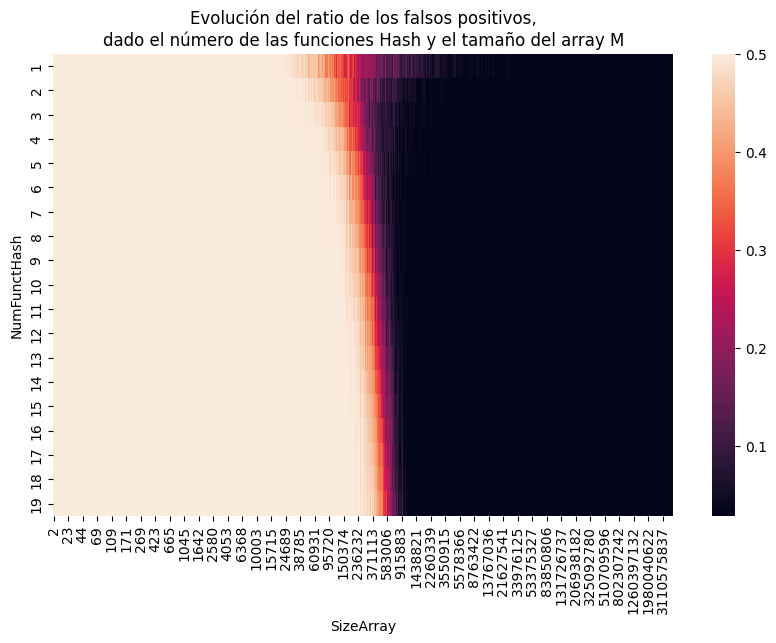

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(df_filter_bloom_stats.pivot_table(values="RateFalsePositive", index="NumFunctHash", columns="SizeArray"),
            ax=ax)
ax.set_title("Evolución del ratio de los falsos positivos,\ndado el número de las funciones Hash y el tamaño del array M")
plt.show()

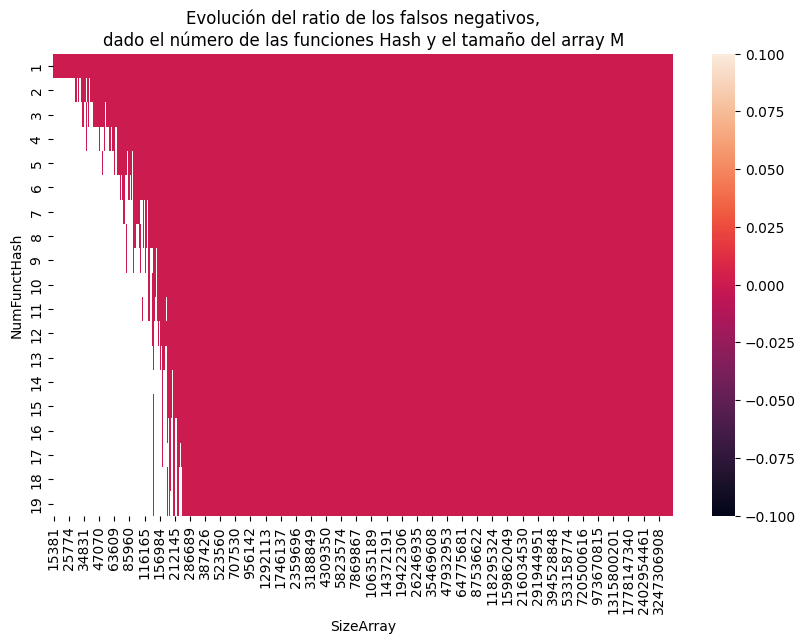

In [17]:
fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(df_filter_bloom_stats.pivot_table(values="RateFalseNegative", index="NumFunctHash", columns="SizeArray"),
            ax=ax)
ax.set_title("Evolución del ratio de los falsos negativos,\ndado el número de las funciones Hash y el tamaño del array M")
plt.show()

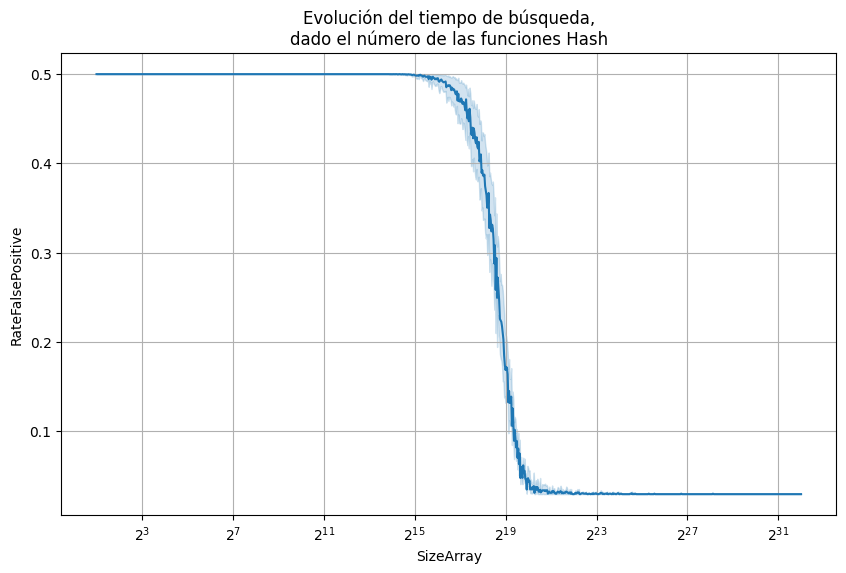

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(df_filter_bloom_stats,
             y="RateFalsePositive",
             x="SizeArray",
             estimator="mean",
             ax=ax
             )
ax.set_xscale("log", base = 2)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el número de las funciones Hash")
ax.grid(True)
plt.show()



$$
f(x)={\frac {L}{1+e^{-k(x-x_{0})}}} [Función Logística]
$$

* $x_{0}$, el valor x del punto medio de la función;

* $L$, el supremo de los valores de la función;

* $k$, la tasa de crecimiento logístico o pendiente de la curva.



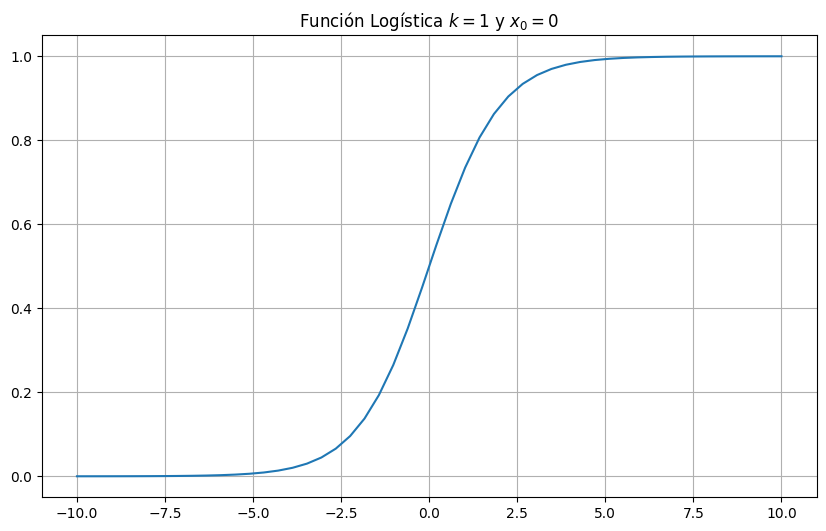

In [19]:
x_aux = np.linspace(-10, 10, dtype=np.float64)
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(y=1/(1+np.exp(-x_aux)),
             x=x_aux,
             ax=ax
             )
ax.set_title(r"Función Logística $k=1$ y $x_0 = 0$")
ax.grid(True)
plt.show()

En nuestro caso, es trivial saber que el valor de $L$ es 0.5, debido que es la cota del ratio de los falsos positivos. Otro motivo de usar esta función, es se calcula el limite de esta función hacia menos infinito resulta dar 0, lo que tiene total sentido, ya que si el filtro tuviera un array de tamaño infinito implicaría tener un Hashing Perfecto, por lo que nunca entregaría falsos positivos el filtro, lo que es precisamente lo que obtenemos en los datos. Además, se puede observar que nuestros datos responden corresponde a una forma de la curva, si se le aplica un $-log_2(\cdot)$ al tamaño del array del filtro. Lo que resulta en el siguiente modelo:

$$
f(x)={\frac {0.5}{1+e^{k(log_2(x)+x_{0})}}} [Modelo]
$$

Aunque los valores de $k$ e $x_0$ no son sencillos de obtener se probará que el modelo es suficientemente parecido a la curva, en cuanto a morfología, probando $k$ = 1 y $x_0$ = 0 (debido que en la gráfica se puede observar que, aproximadamente, es el valor de x cuando la función toma su valor medio).

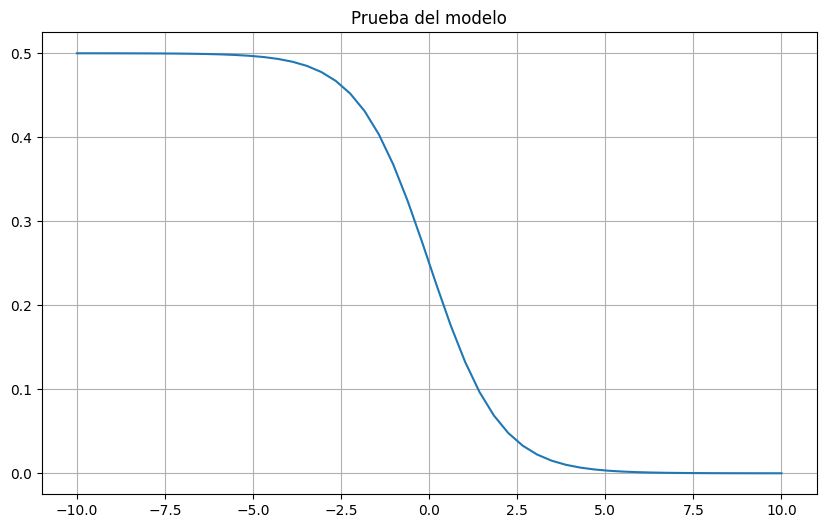

In [20]:
x_aux = np.linspace(-10, 10, dtype=np.float64)
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(y=0.5/(1+np.exp(x_aux)),
             x=x_aux,
             ax=ax
             )
ax.set_title("Prueba del modelo")
ax.grid(True)
plt.show()

Claramente, se observa que el modelo tiene un gran parecido a los datos, por lo que bastaría encontrar  $k$ y  $x_0$ que minimicen el error con los datos, pero antes es importante conocer si estos hiperparametros tienen son dependientes del número de funciones hash que posee el filtro.

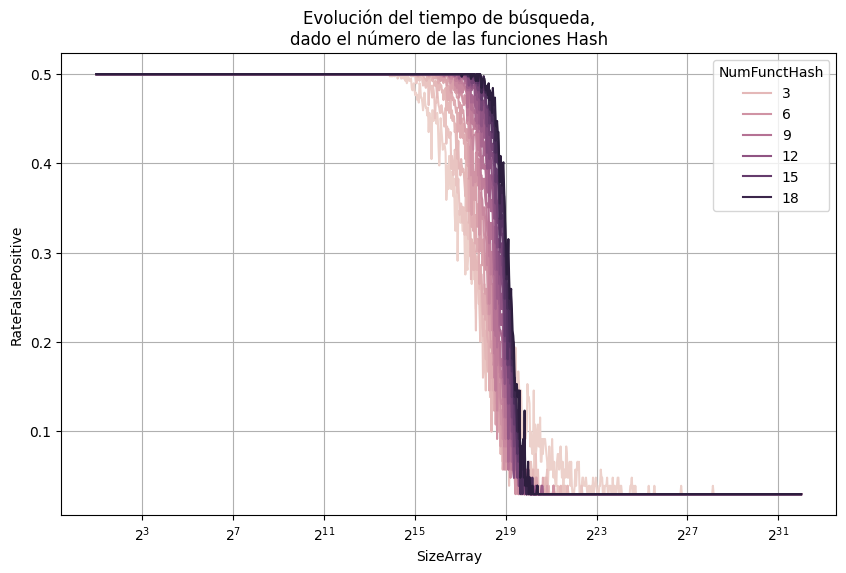

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(df_filter_bloom_stats,
             y="RateFalsePositive",
             x="SizeArray",
             hue="NumFunctHash",
             estimator="mean",
             ax=ax
             )
ax.set_xscale("log", base = 2)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el número de las funciones Hash")
ax.grid(True)
plt.show()

Se puede observar y concluir que los hiperparametros del modelo $k$ y $x_0$ dependen del número de funciones hash que posea el filtro. Entonces, se observará la relación entre el ratio de los falsos positivos y el número de funciones hash.

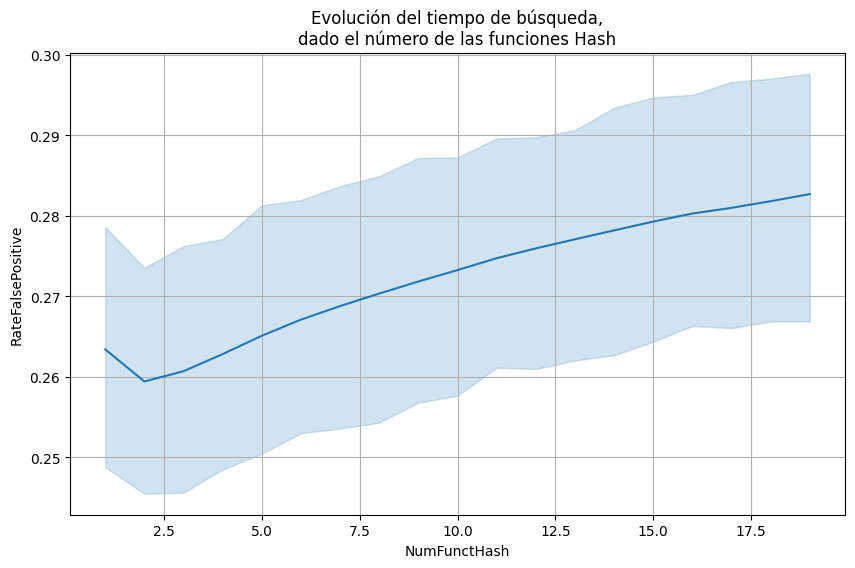

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(df_filter_bloom_stats,
             y="RateFalsePositive",
             x="NumFunctHash",
             estimator="mean",
             ax=ax
             )
ax.set_title("Evolución del tiempo de búsqueda,\ndado el número de las funciones Hash")
ax.grid(True)
plt.show()

El valor promedio del ratio de los falsos positivos del filtro posee demasiada desviación estándar, por lo que calcularemos el valor de cada $k$ y $x_0$ con un número de funciones hash fijo y se graficaran cada uno de los valores obtenido para observer si existe algún modelo que las represente.

In [212]:
import numpy as np

def logistic_function(x, L, k, x0, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

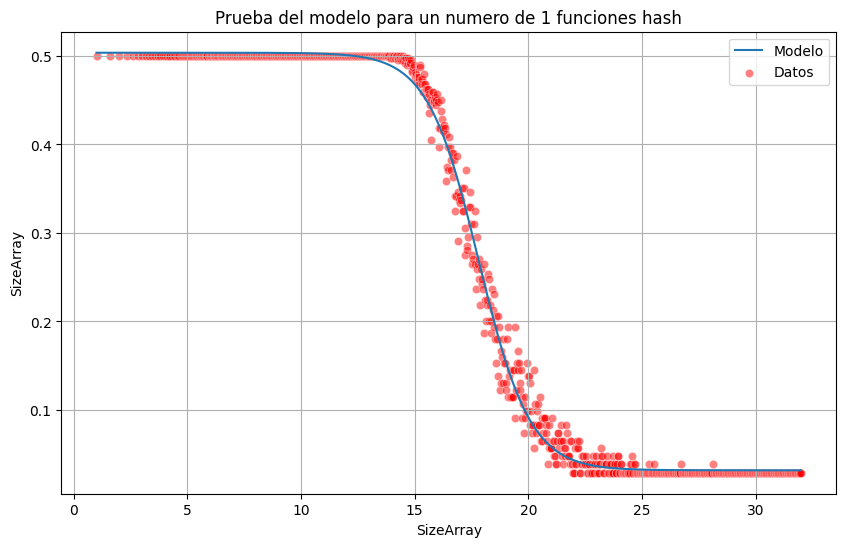

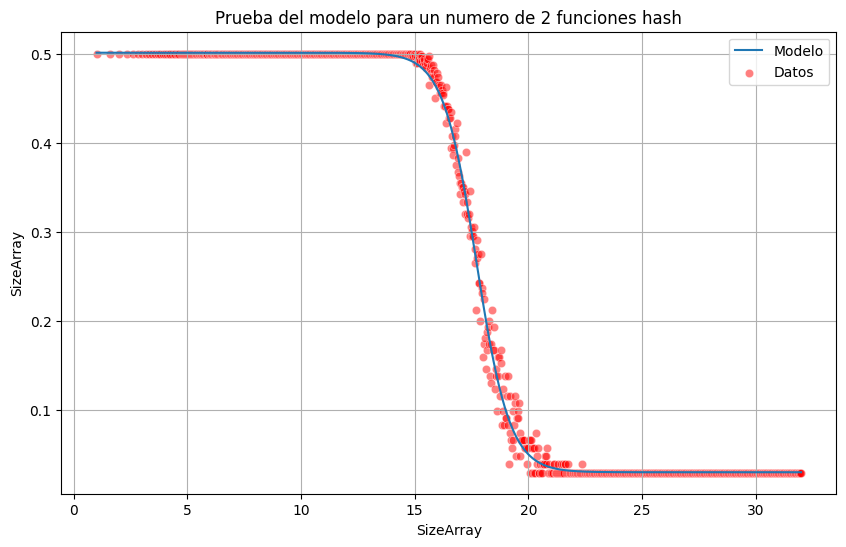

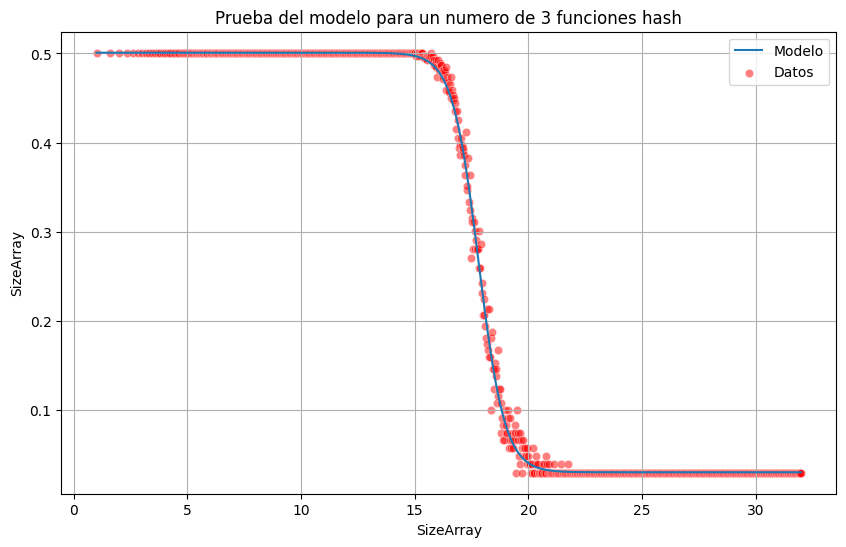

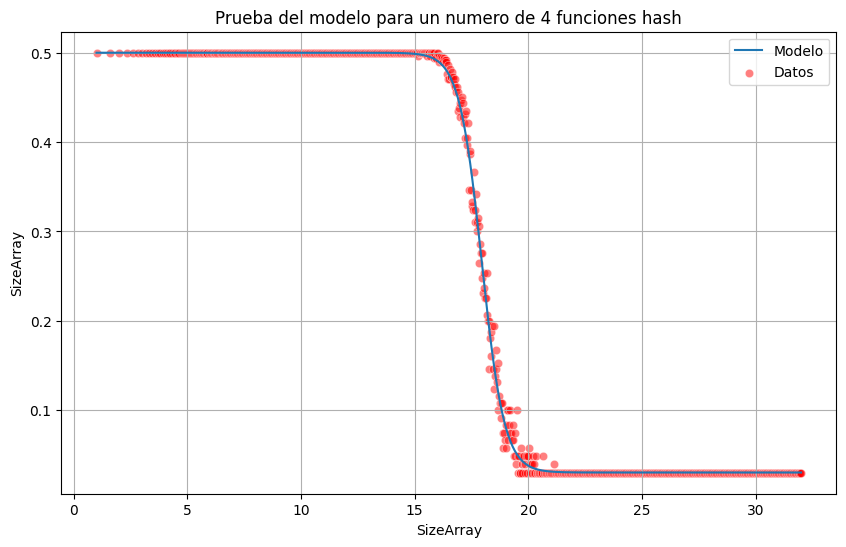

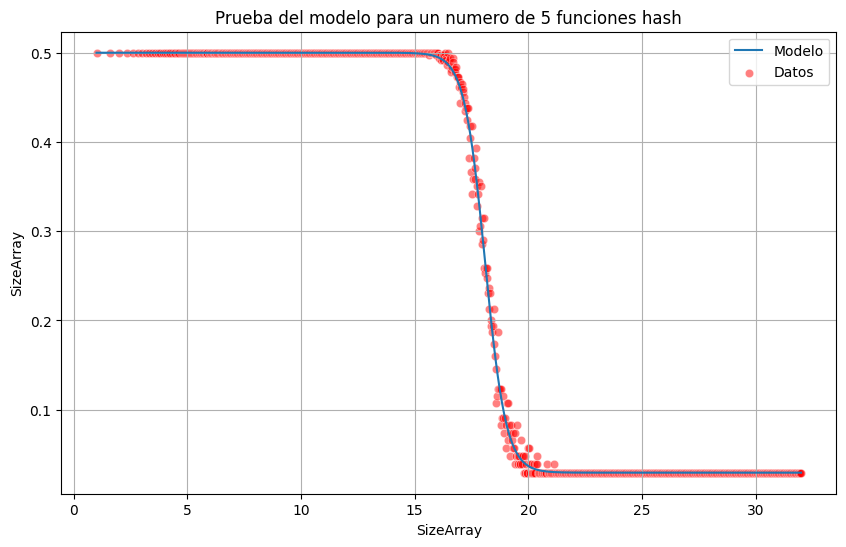

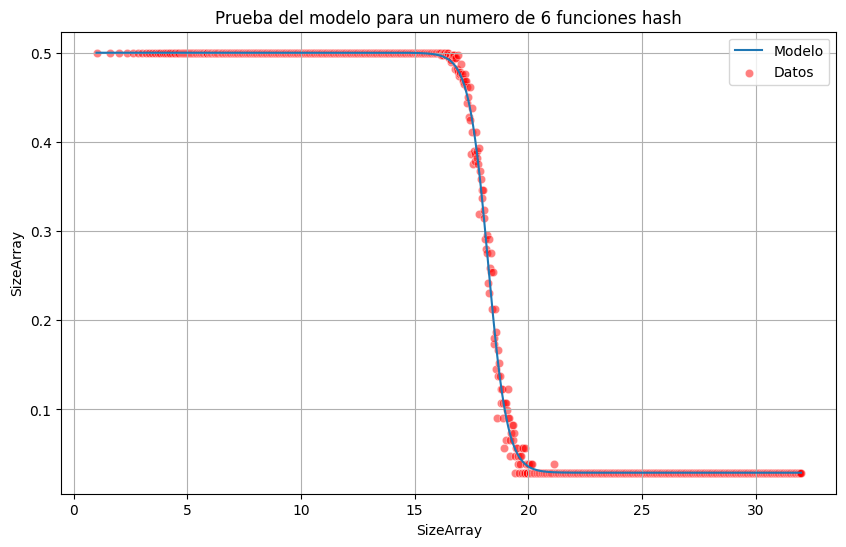

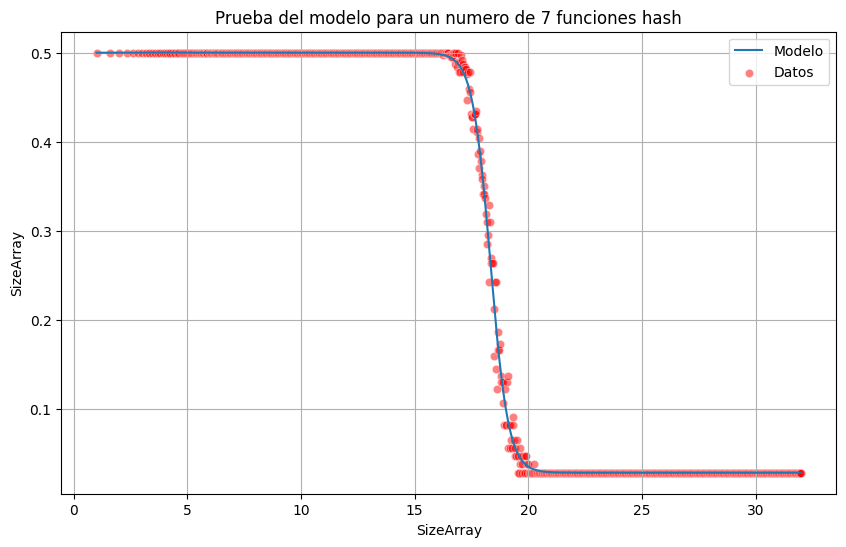

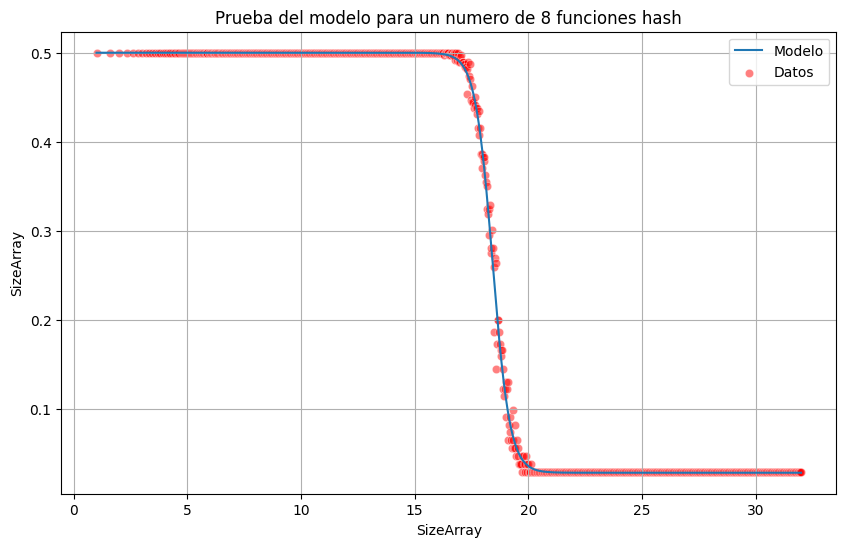

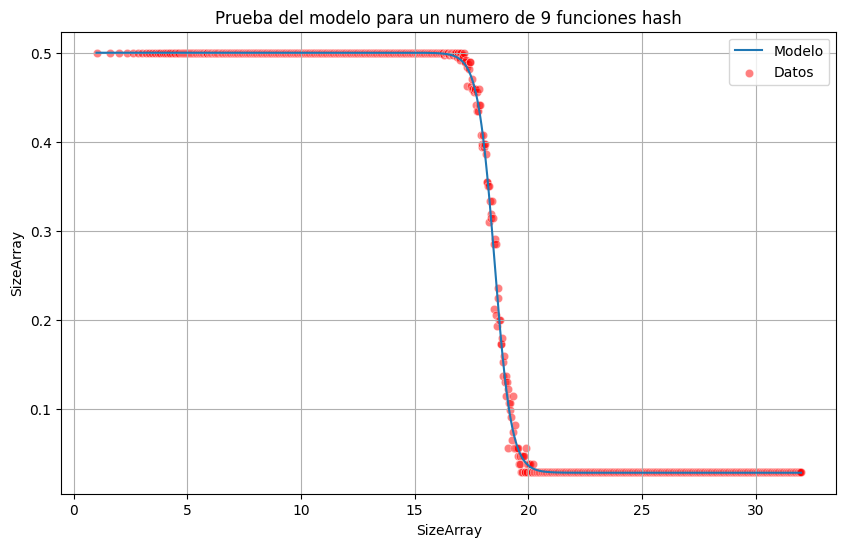

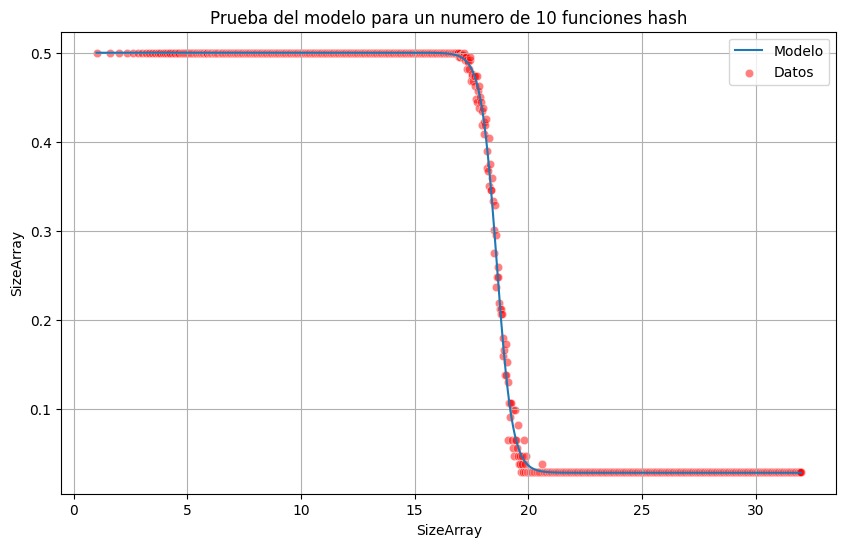

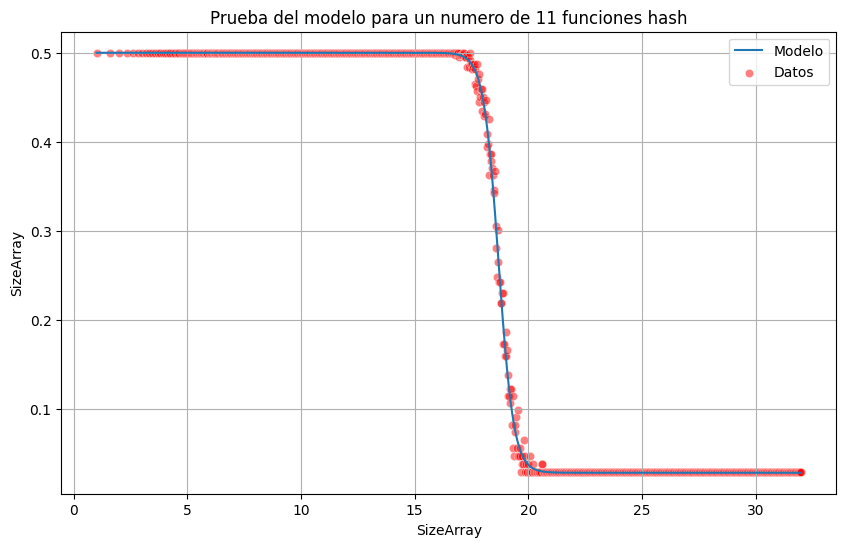

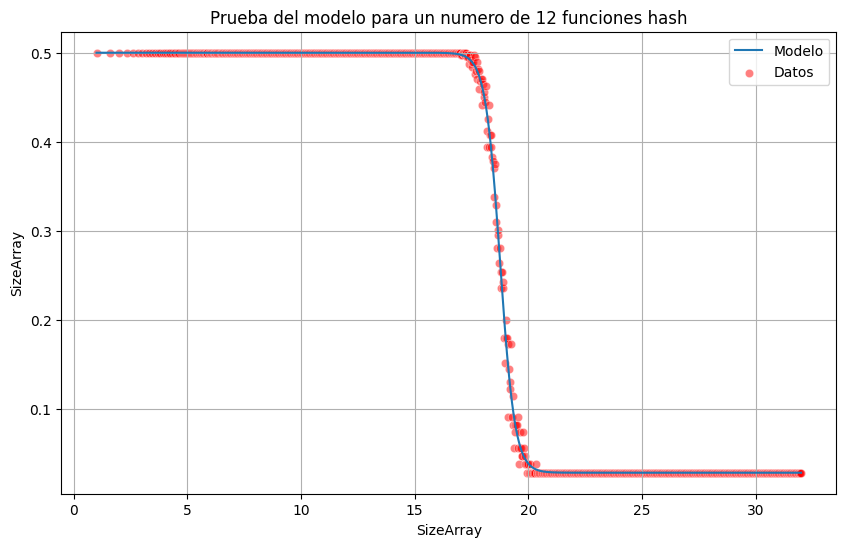

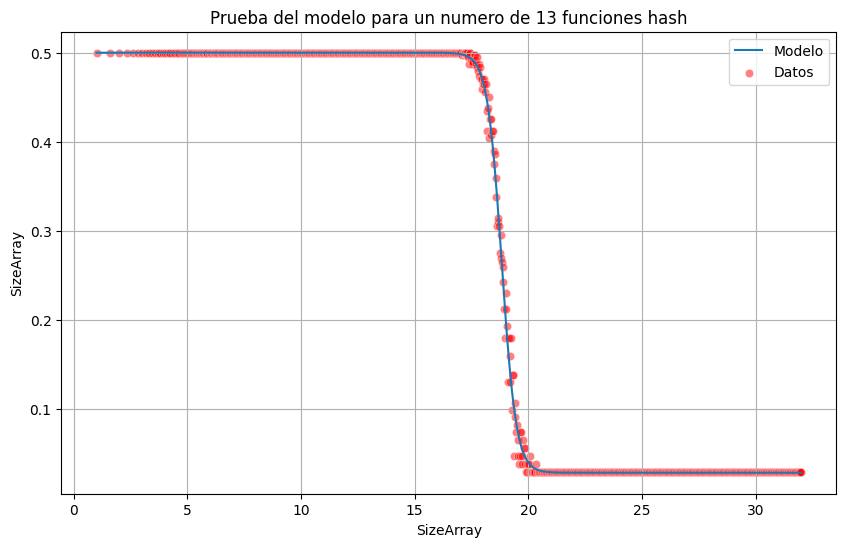

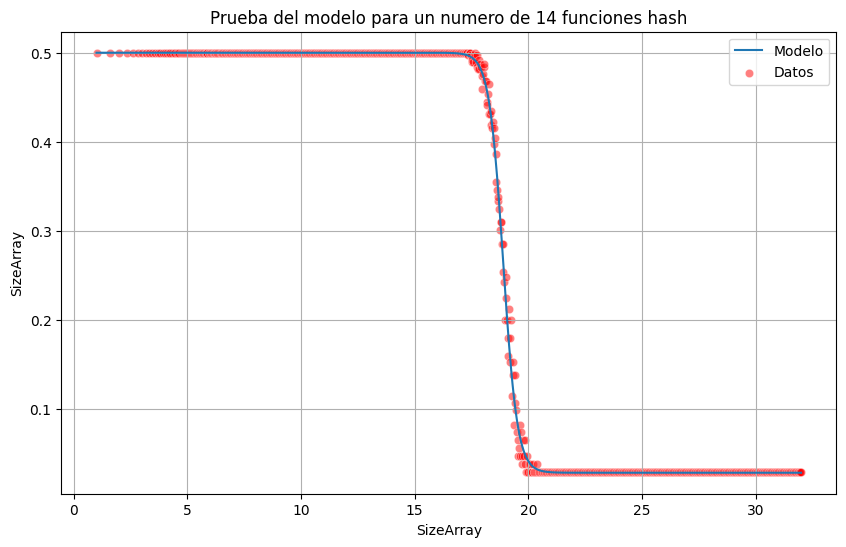

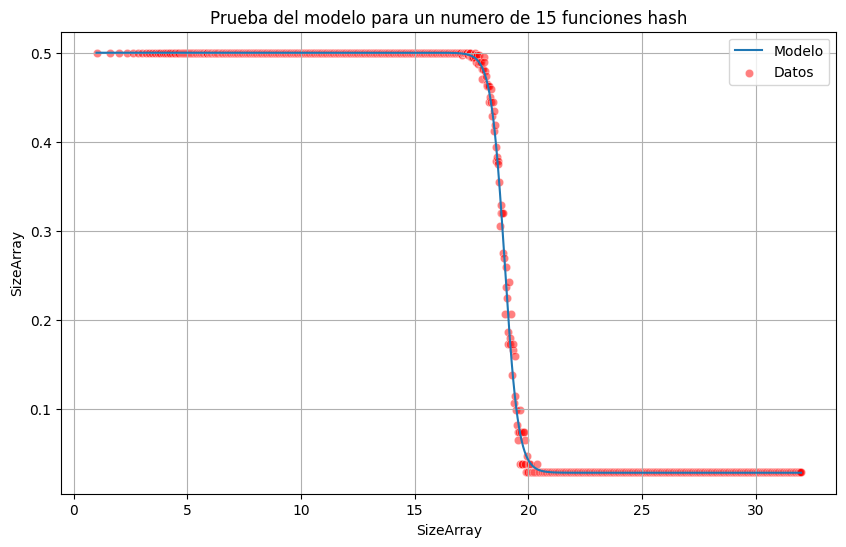

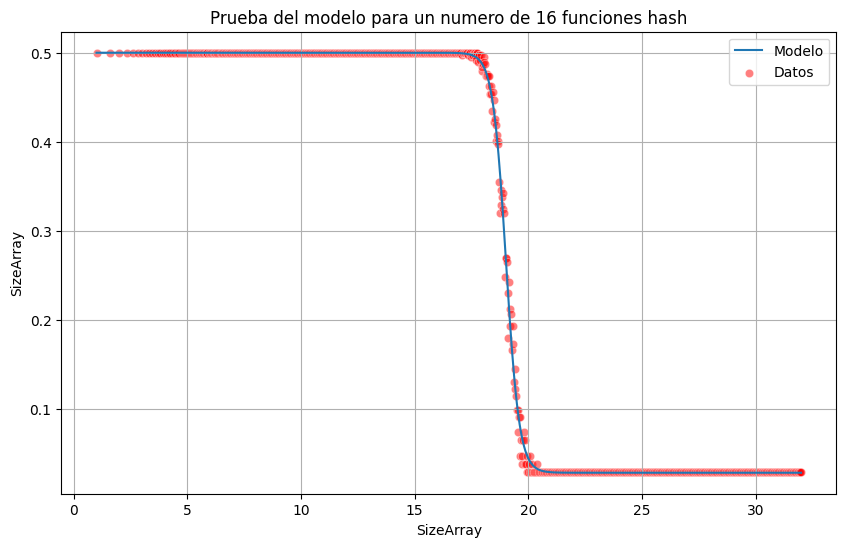

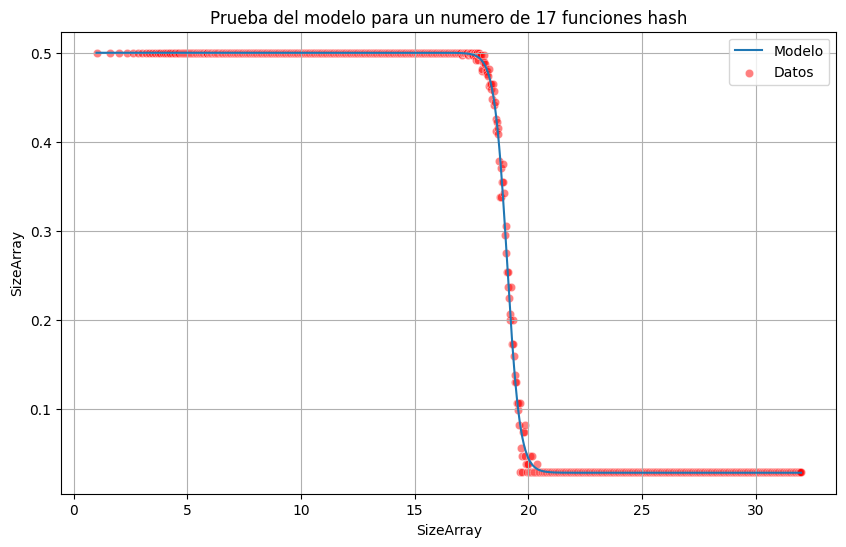

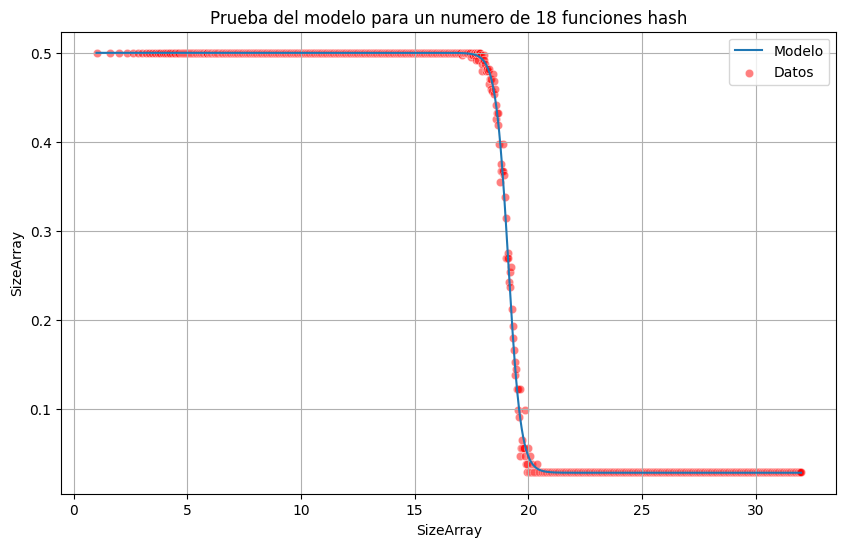

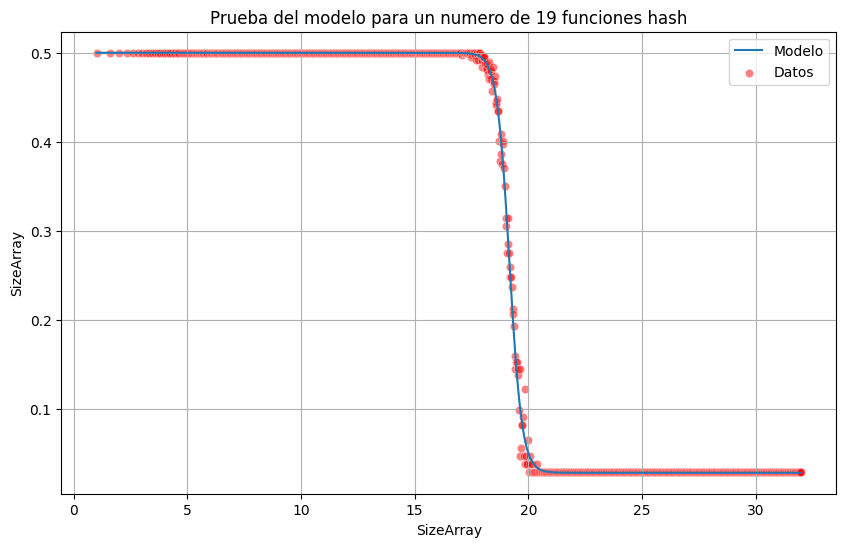

In [226]:
from scipy.optimize import curve_fit

list_L = []
list_k = []
list_x0 = []
list_b = []
list_perror = []

for num_hash in df_filter_bloom_stats["NumFunctHash"].unique():
    # Datos de ejemplo
    x = df_filter_bloom_stats[df_filter_bloom_stats["NumFunctHash"]==num_hash]["SizeArray"]
    x_aux = np.log2(x) 
    y = df_filter_bloom_stats[df_filter_bloom_stats["NumFunctHash"]==num_hash]["RateFalsePositive"]

    # Ajuste de curva
    params, pcov = curve_fit(logistic_function,
                          x_aux,
                          y,
                          [0.5, 10, x_aux.mean(), 0],
                          #bounds=[(0.49,1, 10),(0.51,np.inf,23)],
                          )

    # Parámetros estimados
    L_est, k_est, x0_est, b_est = params


    list_L.append(L_est)
    list_k.append(k_est)
    list_x0.append(x0_est)
    list_b.append(b_est)
    list_perror.append(np.sqrt(np.diag(pcov)))

    fig, ax = plt.subplots(figsize=(10,6))
    sns.lineplot(y=logistic_function(x_aux,L_est,k_est,x0_est,b_est),
                 x=x_aux,
                 ax=ax,
                 label = "Modelo"
                 )
    sns.scatterplot(x=x_aux,
                    y=df_filter_bloom_stats[df_filter_bloom_stats["NumFunctHash"]==num_hash]["RateFalsePositive"],
                    color="red",
                    label ="Datos",
                    alpha= 0.5)
    ax.set_title(f"Prueba del modelo para un numero de {num_hash} funciones hash")
    ax.grid(True)
    plt.show()

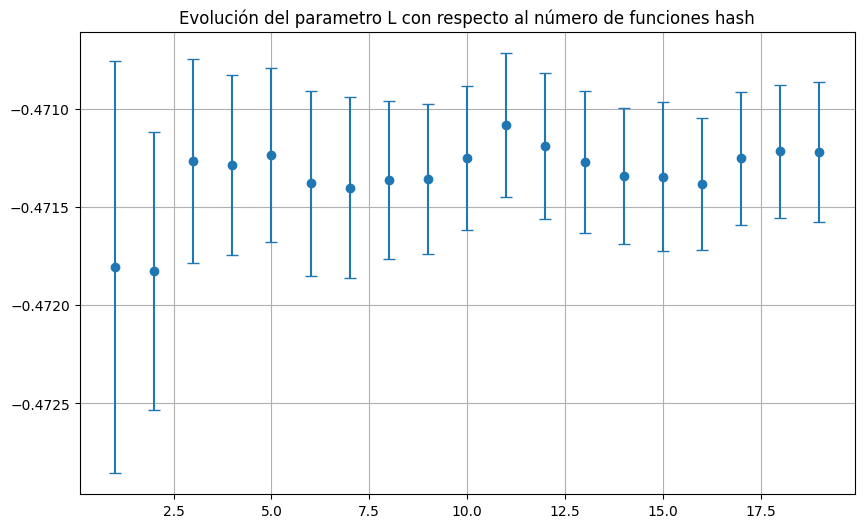

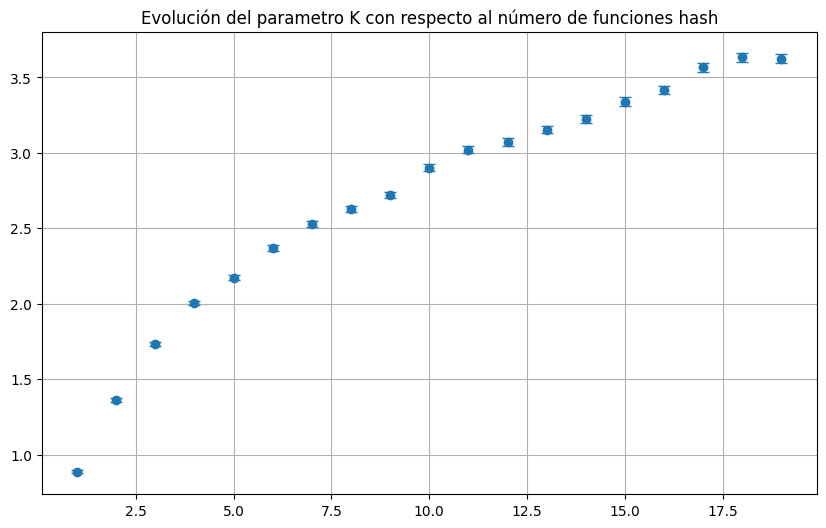

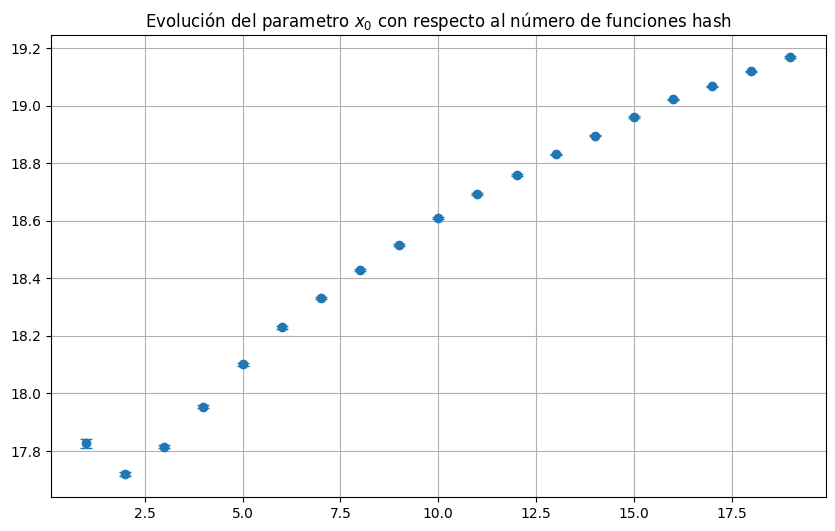

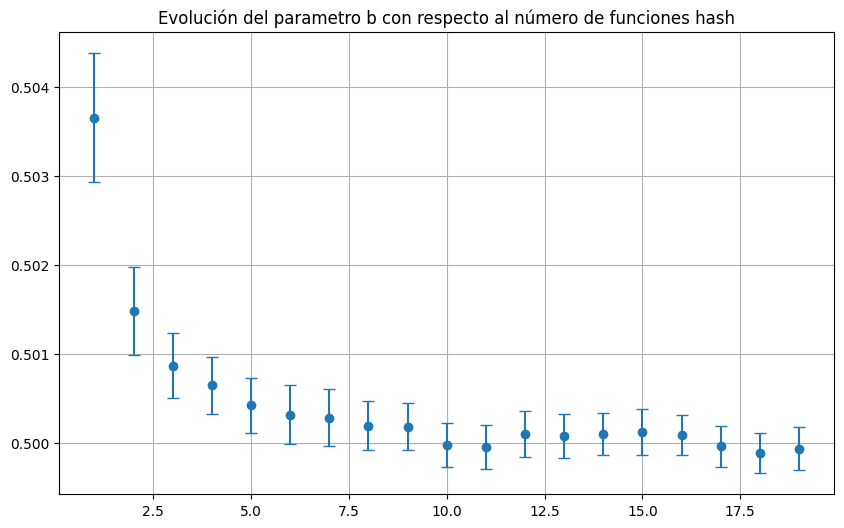

In [235]:
list_params = [list_L,list_k,list_x0,list_b]
name_params = [r"L",r"K",r"$x_0$",r"b"]

for i in range(4):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.errorbar(range(1,len(list_params[i])+1), list_params[i], yerr=[x[i] for x in list_perror], fmt='o', capsize=4)
    ax.grid(True)
    ax.set_title(f"Evolución del parametro {name_params[i]} con respecto al número de funciones hash")
    plt.plot()